# Activity Recognition with Machine Learning

### Overview
- [PAMAP2 Dataset](https://archive.ics.uci.edu/ml/datasets/pamap2+physical+activity+monitoring)
- Human Activity Recognition using Accelerometer worn on the Wrist<br/>
- Predict activity with 5 second accelerometer data

<img src="images/simple_pipeline.png" style='width:70%; margin-bottom:10px'>
<div style='text-align:center; font-weight:bold;'>Figure 1. Data Samples (Walking and Sitting)</div>

#### Import Libraries

In [1]:
from collections import Counter
from glob import glob
import warnings
warnings.filterwarnings(action='ignore')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, GridSearchCV, LeaveOneGroupOut
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
%matplotlib inline

from visualize import plot_confusion_matrix

### 1. Data Analysis

#### A. Get Filepaths with `glob`

In [2]:
filepaths = sorted(glob('data/PAMAP2/*.dat'))
filepaths

['data/PAMAP2/subject101.dat',
 'data/PAMAP2/subject102.dat',
 'data/PAMAP2/subject103.dat',
 'data/PAMAP2/subject104.dat',
 'data/PAMAP2/subject105.dat',
 'data/PAMAP2/subject106.dat',
 'data/PAMAP2/subject107.dat',
 'data/PAMAP2/subject108.dat',
 'data/PAMAP2/subject109.dat']

#### B. Load File

In [3]:
filepath = filepaths[0]
df = pd.read_csv(filepath, delimiter=' ', header=None)
print(df.shape)
df.head()

(376417, 54)


0   1      2     3        4        5        6        7        8   \
0  8.38   0  104.0  30.0  2.37223  8.60074  3.51048  2.43954  8.76165   
1  8.39   0    NaN  30.0  2.18837  8.56560  3.66179  2.39494  8.55081   
2  8.40   0    NaN  30.0  2.37357  8.60107  3.54898  2.30514  8.53644   
3  8.41   0    NaN  30.0  2.07473  8.52853  3.66021  2.33528  8.53622   
4  8.42   0    NaN  30.0  2.22936  8.83122  3.70000  2.23055  8.59741   

        9   ...        44        45        46       47       48       49   50  \
0  3.35465  ...  0.008300  0.009250 -0.017580 -61.1888 -38.9599 -58.1438  1.0   
1  3.64207  ... -0.006577 -0.004638  0.000368 -59.8479 -38.8919 -58.5253  1.0   
2  3.73280  ...  0.003014  0.000148  0.022495 -60.7361 -39.4138 -58.3999  1.0   
3  3.73277  ...  0.003175 -0.020301  0.011275 -60.4091 -38.7635 -58.3956  1.0   
4  3.76295  ...  0.012698 -0.014303 -0.002823 -61.5199 -39.3879 -58.2694  1.0   

    51   52   53  
0  0.0  0.0  0.0  
1  0.0  0.0  0.0  
2  0.0  0.0  0.0  
3  0.0  0.0  0.0  
4  0.0  0.0  0.0  

[5 rows x 54 columns]

#### C. Select Data using Dataset Documentation

In [4]:
# Columns from dataset documentation
time_column = 0
label_column = 1
data_columns = {
    'hand': [4, 5, 6],
    'chest': [21, 22, 23],
    'ankle': [38, 39, 40],
}

# Select data to use
time = df[time_column]
label = df[label_column]
data = df[data_columns['hand']]

print(time.shape, label.shape, data.shape)

(376417,) (376417,) (376417, 3)


In [5]:
Counter(label)

Counter({0: 126460,
         1: 27187,
         2: 23480,
         3: 21717,
         17: 23573,
         16: 22941,
         12: 15890,
         13: 14899,
         4: 22253,
         7: 20265,
         6: 23575,
         5: 21265,
         24: 12912})

In [6]:
# Labels from dataset documentation
label_map = {
    1: 'lying',
    2: 'sitting',
    3: 'standing',
    4: 'walking',
    5: 'running',
    6: 'cycling',
    7: 'Nordic walking',
    9: 'watching TV',
    10: 'computer work',
    11: 'car driving',
    12: 'ascending stairs',
    13: 'descending stairs',
    16: 'vacuum cleaning',
    17: 'ironing',
    18: 'folding laundry',
    19: 'house cleaning',
    20: 'playing soccer',
    24: 'rope jumping',
    0: 'other (transient activities)',
}

#### D. Plot Data

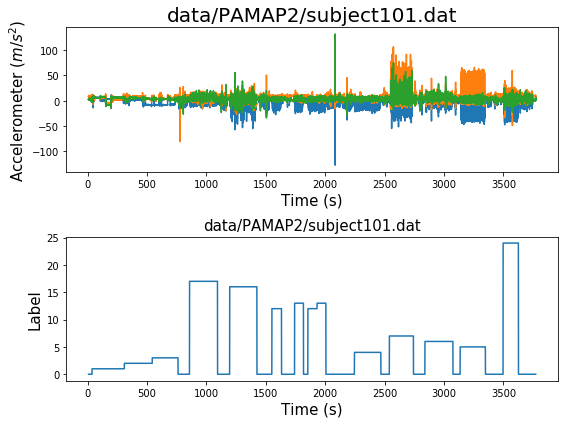

In [7]:
fig, ax = plt.subplots(nrows=2, figsize=(8, 6))

# Plot accelerometer data
ax[0].plot(time, data)
ax[0].set_title(filepath, fontsize=20)
ax[0].set_xlabel('Time (s)', fontsize=15)
ax[0].set_ylabel('Accelerometer ($m/s^2$)', fontsize=15)

# Plot label data
ax[1].plot(time, label)
ax[1].set_title(filepath, fontsize=15)
ax[1].set_xlabel('Time (s)', fontsize=15)
ax[1].set_ylabel('Label', fontsize=15)

fig.tight_layout()
fig.show()

### 2. Preprocessing

#### A. Drop NaN

In [8]:
data = data.dropna(axis='index')

#### B. Sliding Window
* Practice: Implement Sliding Window [10분]
  * Apply sliding window to 2D array, `data`.
  * Please refer to the ppt slide.

In [9]:
def most_common(l):
    """
    Find most common element in the list.
    
    Parameters
    ----------
    l : list
        list to find most common element
    
    Returns
    -------
    most common element
    """
    return Counter(l).most_common(1)[0][0]


def sliding_window(data, label, window_size, stride_size):
    """
    Apply sliding window to 2D array.
    Returns array of sliding windows.
    
    Parameters
    ----------
    data : array-like of shape (n_samples, num_features)
        X samples
    
    label : array-like of shape (n_samples,)
        y samples
    
    window_size : int
        Size of single window
    
    stride_size : int
        Space between windows
    
    Returns
    -------
    sliding_windows : array-like of shape (n_windows, window_size, num_features)
        Array of sliding windows

    labels : array-like of shape (n_windows,)
        Array of labels for each sliding window
    """
    sliding_windows, labels = [], []
    
    
    
    return sliding_windows, labels

In [10]:
sampling_rate = 100  # From dataset documentation
window_size = int(5 * sampling_rate)
stride_size = int(2.5 * sampling_rate)

X, Y = sliding_window(data, label, window_size, stride_size)
print(X.shape, Y.shape)

(1498, 500, 3) (1498,)


In [11]:
Counter(Y)

Counter({0: 497,
         1: 109,
         2: 94,
         3: 87,
         17: 95,
         16: 91,
         12: 63,
         13: 60,
         4: 89,
         7: 81,
         6: 94,
         5: 86,
         24: 52})

#### C. Drop "No Activity" Samples (Optional)

In [12]:
no_activity_label = 0

mask = Y != no_activity_label
X, Y = X[mask], Y[mask]
print(X.shape, Y.shape)

(1001, 500, 3) (1001,)


#### D. Plot Single Window

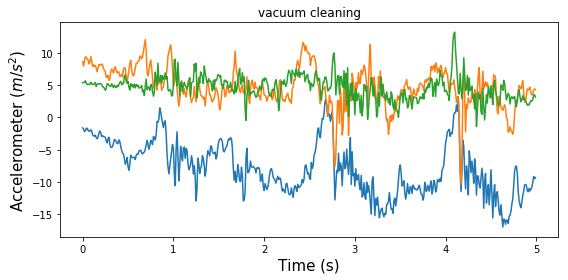

In [13]:
# Select single window
sample_index = 400
X_sample, Y_sample = X[sample_index], Y[sample_index]
time = np.arange(window_size) / sampling_rate

# Plot single window
fig, ax = plt.subplots(figsize=(8,4))

ax.plot(time, X_sample)
ax.set_title(label_map[Y_sample])
ax.set_xlabel('Time (s)', fontsize=15)
ax.set_ylabel('Accelerometer ($m/s^2$)', fontsize=15)

fig.tight_layout()
fig.show()

### 3. Feature Extraction

In [14]:
def _extract_time_domain_features(X_sample):
    """
    Extract time domain features from single window
    
    Parameters
    ----------
    X_sample : array-like of shape (500, 3)
        axis 0 => time
        axis 1 => x, y, z axis
    
    Returns
    -------
    features : array-like of shape (num_features,)
        list of extracted time domain features from single window
    """
    # Extract time domain features
    mean = np.mean(X_sample, axis=0) # Mean per axis
    std = np.std(X_sample, axis=0)   # Standard deviation per axis
    x, y, z = X_sample[:,0], X_sample[:,1], X_sample[:,2]
    xy_corr = np.corrcoef(x, y)[0,1] # Correlation between x, y axis
    yz_corr = np.corrcoef(y, z)[0,1] # Correlation between y, z axis
    zx_corr = np.corrcoef(z, x)[0,1] # Correlation between z, x axis

    # Concatenate extracted features
    features = np.hstack([mean, std, xy_corr, yz_corr, zx_corr])
    return features


def _extract_frequency_domain_features(X_sample):
    """
    Extract frequency domain features from single window
    
    Parameters
    ----------
    X_sample : array-like of shape (500, 3)
        axis 0 => time
        axis 1 => x, y, z axis
    
    Returns
    -------
    features : array-like of shape (num_features,)
        list of extracted frequency domain features from single window
    """
    # Fourier Transform
    X_fft = np.abs(np.fft.fft(X_sample, axis=0))[1:]
    
    # Extract frequency domain features
    entropy = stats.entropy(X_fft, axis=0) # The degree of spread across multiple frequencies per axis
    energy = np.sum(X_fft**2, axis=0)      # Energy per axis
    
    # Concatenate extracted features
    features = np.hstack([entropy, energy])
    return features


def extract_features(X_samples):
    """
    Extract features from multiple windows
    
    Parameters
    ----------
    X_samples : array-like of shape (num_samples, 500, 3)
        axis 0 => samples
        axis 1 => time
        axis 2 => x, y, z axis
    
    Returns
    -------
    X_features : array-like of shape (num_samples, num_features)
        Extracted features from multiple windows
    """
    X_time_features = np.array([_extract_time_domain_features(X_sample) for X_sample in X_samples])
    X_freq_features = np.array([_extract_frequency_domain_features(X_sample) for X_sample in X_samples])
    
    X_features = np.hstack([X_time_features, X_freq_features])
    return X_features

In [15]:
X_features = extract_features(X)
print(X_features.shape)

(1001, 15)


### 4. Classification and Evaluation

#### A. Train/Test with Single Subject

##### Train/Test split with single subject

In [16]:
X_train, X_test, Y_train, Y_test = train_test_split(X_features, Y, test_size=0.2, stratify=Y)
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(800, 15) (201, 15) (800,) (201,)


##### Train classifier

In [17]:
clf = RandomForestClassifier()
clf.fit(X_train, Y_train)
Y_pred = clf.predict(X_test)

##### Evaluation

In [18]:
target_names = [label_map[label] for label in sorted(set(Y_train))]
print(classification_report(Y_test, Y_pred, target_names=target_names))
plot_confusion_matrix(Y_test, Y_pred, target_names=target_names)

                   precision    recall  f1-score   support

            lying       1.00      0.95      0.98        22
          sitting       0.86      0.95      0.90        19
         standing       0.76      0.89      0.82        18
          walking       1.00      0.78      0.88        18
          running       1.00      0.82      0.90        17
          cycling       1.00      1.00      1.00        19
   Nordic walking       1.00      1.00      1.00        16
 ascending stairs       0.80      0.92      0.86        13
descending stairs       0.77      0.83      0.80        12
  vacuum cleaning       1.00      0.83      0.91        18
          ironing       0.85      0.89      0.87        19
     rope jumping       0.83      1.00      0.91        10

         accuracy                           0.91       201
        macro avg       0.91      0.91      0.90       201
     weighted avg       0.92      0.91      0.91       201



#### B. Different Train/Test Subject

##### Train/Test split with multiple subjects

In [19]:
filepaths

['data/PAMAP2/subject101.dat',
 'data/PAMAP2/subject102.dat',
 'data/PAMAP2/subject103.dat',
 'data/PAMAP2/subject104.dat',
 'data/PAMAP2/subject105.dat',
 'data/PAMAP2/subject106.dat',
 'data/PAMAP2/subject107.dat',
 'data/PAMAP2/subject108.dat',
 'data/PAMAP2/subject109.dat']

In [20]:
Xs, Ys = [], []
for idx, filepath in enumerate(filepaths):
    # Load data
    df = pd.read_csv(filepath, delimiter=' ', header=None)

    # Select time, label, data columns
    time = df[time_column]
    label = df[label_column]
    data = df[data_columns['hand']]
    
    # Drop rows with NaN values
    data = data.dropna(axis='index')
    
    # Sliding window
    X, Y = sliding_window(data, label, window_size, stride_size)
    
    # Drop "No Activity" samples
    mask = Y != 0
    X, Y = X[mask], Y[mask]
    
    # Add to Train/Test data
    Xs.append(X)
    Ys.append(Y)

X = np.vstack(Xs)
Y = np.hstack(Ys)
print(X.shape, Y.shape)

(7757, 500, 3) (7757,)


In [21]:
X_features = extract_features(X)
print(X_features.shape)

(7757, 15)


In [22]:
X_train, X_test, Y_train, Y_test = train_test_split(X_features, Y, test_size=0.2, stratify=Y)
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(6205, 15) (1552, 15) (6205,) (1552,)


##### Train classifier

In [23]:
clf = RandomForestClassifier()
clf.fit(X_train, Y_train)
Y_pred = clf.predict(X_test)

##### Evaluation

In [24]:
target_names = [label_map[label] for label in sorted(set(Y_train))]
print(classification_report(Y_test, Y_pred, target_names=target_names))
plot_confusion_matrix(Y_test, Y_pred, target_names=target_names)

                   precision    recall  f1-score   support

            lying       0.99      0.86      0.92       154
          sitting       0.81      0.84      0.83       148
         standing       0.78      0.91      0.84       152
          walking       0.95      0.90      0.92       191
          running       1.00      0.94      0.97        78
          cycling       0.97      0.89      0.93       132
   Nordic walking       1.00      0.94      0.97       150
 ascending stairs       0.82      0.78      0.80        94
descending stairs       0.80      0.71      0.75        84
  vacuum cleaning       0.88      0.89      0.88       140
          ironing       0.78      0.95      0.86       191
     rope jumping       0.97      0.79      0.87        38

         accuracy                           0.88      1552
        macro avg       0.90      0.87      0.88      1552
     weighted avg       0.89      0.88      0.88      1552



#### Practice : Correct Train/Test Split with Multiple Subjects [15분]
* Train/Test data should not contain same subject.
* Split train/test data with non-overlapping subjects.

In [ ]:
# Split train/test data with non-overlapping subjects





X_train = None
Y_train = None
X_test = None
Y_test = None

##### Train Classifier

##### Evaluation

### 6. Different Classifiers

#### A. Decision Tree `DecisionTreeClassifier`

In [ ]:
clf = DecisionTreeClassifier()
clf.fit(X_train, Y_train)
Y_pred = clf.predict(X_test)

print(classification_report(Y_test, Y_pred, target_names=target_names))
plot_confusion_matrix(Y_test, Y_pred, target_names=target_names)

In [ ]:
plot_tree(clf)

#### B. Logistic Regression `LogisticRegression`

In [ ]:
clf = LogisticRegression()
clf.fit(X_train, Y_train)
Y_pred = clf.predict(X_test)

print(classification_report(Y_test, Y_pred, target_names=target_names))
plot_confusion_matrix(Y_test, Y_pred, target_names=target_names)

#### C. Linear Discriminant Analysis `LinearDiscriminantAnalysis`

In [ ]:
clf = LinearDiscriminantAnalysis()
clf.fit(X_train, Y_train)
Y_pred = clf.predict(X_test)

print(classification_report(Y_test, Y_pred, target_names=target_names))
plot_confusion_matrix(Y_test, Y_pred, target_names=target_names)

#### D. Practice: Try various classifiers [5분]
1. Support Vector Machines `SVC`

2. Random Forest `RandomForestClassifier`

3. Boosting `AdaBoostClassifier`

### 7. Hyperparameter Tuning

#### A. Tunable Parameters

In [ ]:
clf = DecisionTreeClassifier()
clf.get_params()

#### B. Grid Search

In [ ]:
param_grid = {
    'max_depth': [1, 2, 3, 4, 5, 10, 15, 20, 25, 30],
}
cv = GridSearchCV(
    clf,
    param_grid,
    scoring='accuracy',
    cv=LeaveOneGroupOut(),
)

In [ ]:
cv.fit(X, Y, groups)

In [ ]:
cv.cv_results_

### 8. Mini Competition
#### Get highest accuracy!
* 상품
  * 1등 10000원
  * 2, 3등 5000원
* All kinds of classifiers are available.
* Train / Test
  * Test subject : subject101 ~ subject102
  * Train subject : subject103 ~ subject109